# 1 - Modelo XGBOOST CLASSIFIER

In [11]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#model = xgb.XGBClassifier(n_estimators=7, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')
model = xgb.XGBClassifier(n_estimators=7)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=7, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## 1.1 Predições do Modelo

In [12]:
y_pred = model.predict(X_test)
print(X_test)
print(y_pred)

[[6.1 2.8 4.7 1.2]
 [5.7 3.8 1.7 0.3]
 [7.7 2.6 6.9 2.3]
 [6.  2.9 4.5 1.5]
 [6.8 2.8 4.8 1.4]
 [5.4 3.4 1.5 0.4]
 [5.6 2.9 3.6 1.3]
 [6.9 3.1 5.1 2.3]
 [6.2 2.2 4.5 1.5]
 [5.8 2.7 3.9 1.2]
 [6.5 3.2 5.1 2. ]
 [4.8 3.  1.4 0.1]
 [5.5 3.5 1.3 0.2]
 [4.9 3.1 1.5 0.1]
 [5.1 3.8 1.5 0.3]
 [6.3 3.3 4.7 1.6]
 [6.5 3.  5.8 2.2]
 [5.6 2.5 3.9 1.1]
 [5.7 2.8 4.5 1.3]
 [6.4 2.8 5.6 2.2]
 [4.7 3.2 1.6 0.2]
 [6.1 3.  4.9 1.8]
 [5.  3.4 1.6 0.4]
 [6.4 2.8 5.6 2.1]
 [7.9 3.8 6.4 2. ]
 [6.7 3.  5.2 2.3]
 [6.7 2.5 5.8 1.8]
 [6.8 3.2 5.9 2.3]
 [4.8 3.  1.4 0.3]
 [4.8 3.1 1.6 0.2]]
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


## 1.2 Criando Booster para Resgatar as Informações das Árvores

In [13]:
booster = model.get_booster()
trees = booster.get_dump(with_stats=False)

In [14]:
booster.save_model('model.json')

In [15]:
trees = booster.get_dump(with_stats=False, dump_format='json')
print(trees)

['  { "nodeid": 0, "depth": 0, "split": "f2", "split_condition": 3, "yes": 1, "no": 2, "missing": 2 , "children": [\n    { "nodeid": 1, "leaf": 0.426035523 }, \n    { "nodeid": 2, "leaf": -0.218845025 }\n  ]}', '  { "nodeid": 0, "depth": 0, "split": "f2", "split_condition": 3, "yes": 1, "no": 2, "missing": 2 , "children": [\n    { "nodeid": 1, "leaf": -0.213017777 }, \n    { "nodeid": 2, "depth": 1, "split": "f3", "split_condition": 1.79999995, "yes": 3, "no": 4, "missing": 4 , "children": [\n      { "nodeid": 3, "depth": 2, "split": "f2", "split_condition": 5, "yes": 5, "no": 6, "missing": 6 , "children": [\n        { "nodeid": 5, "leaf": 0.409090936 }, \n        { "nodeid": 6, "depth": 3, "split": "f3", "split_condition": 1.60000002, "yes": 9, "no": 10, "missing": 10 , "children": [\n          { "nodeid": 9, "leaf": -0.128571451 }, \n          { "nodeid": 10, "leaf": 0.128571421 }\n        ]}\n      ]}, \n      { "nodeid": 4, "depth": 2, "split": "f2", "split_condition": 4.9000001, "

## 1.3 Salvando Árvores em um Json

In [16]:
import json
trees = booster.get_dump(with_stats=False, dump_format='json')
trees = [json.loads(tree) for tree in trees]

with open('trees.json', 'w') as json_file:
    json.dump(trees, json_file, indent=4)

print("Árvores salvas em 'trees.json'.")

Árvores salvas em 'trees.json'.


# 2 - Construção do My Predict

## 2.1 Tipo do Dado de Entrada

In [17]:
list(X_test[1]), X_test[0]

([5.7, 3.8, 1.7, 0.3], array([6.1, 2.8, 4.7, 1.2]))

## 2.2 Primeira Tentativa

In [18]:
import json

with open("/content/trees.json") as f:
    trees = json.load(f)

def predict_tree(tree, X):
    node = tree
    while "leaf" not in node:
        feature_index = int(node["split"][1:])  # "f2" -> 2 (pegar o índice da feature)
        if X[feature_index] < node["split_condition"]:
            node = next(child for child in node["children"] if child["nodeid"] == node["yes"])
        else:
            node = next(child for child in node["children"] if child["nodeid"] == node["no"])
    return node["leaf"]

def predict(trees, X):
    prediction = 0
    for i, tree in enumerate(trees):
        leaf_value = predict_tree(tree, X)
        prediction += leaf_value
        #print(f"Árvore {i+1}: Valor da folha = {leaf_value}")  # Printar o valor da folha de cada árvore
    #print(f"Última árvore {i+1}: Valor da folha final = {leaf_value}")
    return prediction

### 2.2.2 Predição

In [19]:
for i in X_test:
  y = predict(trees, i)
  print("Predição final:", y)


Predição final: -0.7728314249999999
Predição final: -0.7158851309999998
Predição final: -0.712067231
Predição final: -0.3503836783
Predição final: -0.7728314249999999
Predição final: -0.7158851309999998
Predição final: -0.7728314249999999
Predição final: -1.0013919280999999
Predição final: -0.1652944104
Predição final: -0.7728314249999999
Predição final: -1.0013919280999999
Predição final: -0.7158851309999998
Predição final: -0.7158851309999998
Predição final: -0.7158851309999998
Predição final: -0.7158851309999998
Predição final: -0.3503836783
Predição final: -0.712067231
Predição final: -0.7102380839999999
Predição final: -0.7728314249999999
Predição final: -0.712067231
Predição final: -0.7158851309999998
Predição final: -0.13970521096345473
Predição final: -0.7158851309999998
Predição final: -0.712067231
Predição final: -0.712067231
Predição final: -0.712067231
Predição final: -0.712067231
Predição final: -0.712067231
Predição final: -0.7158851309999998
Predição final: -0.7158851309

## 2.3 Segunda Tentativa

In [20]:
import json
import numpy as np

def load_trees_from_json(file_path):
    with open(file_path, 'r') as f:
        trees = json.load(f)
    return trees

def predict_single(tree, sample):
    node = tree  # inicia pela raiz da árvore
    while 'leaf' not in node:
        split_feature = int(node['split'][1:])  # extrai o índice da feature, ex: 'f2' -> 2
        split_condition = node['split_condition']

        # condição de divisão com base na amostra
        if sample[split_feature] < split_condition:
            node = next(child for child in node['children'] if child['nodeid'] == node['yes'])
        else:
            node = next(child for child in node['children'] if child['nodeid'] == node['no'])
    return node['leaf']

def predict(trees, samples):
    predictions = []
    for sample in samples:
        pred = 0
        for tree in trees:
            pred += predict_single(tree, sample)  # Soma as previsões de todas as árvores
        predictions.append(pred)
    return predictions

if __name__ == "__main__":
    t = list()
    trees = load_trees_from_json('trees.json')


    predictions = predict(trees, X_test)
    for i, pred in enumerate(predictions):
        print(f"{pred}")
        t.append(pred)


-0.7728314249999999
-0.7158851309999998
-0.712067231
-0.3503836783
-0.7728314249999999
-0.7158851309999998
-0.7728314249999999
-1.0013919280999999
-0.1652944104
-0.7728314249999999
-1.0013919280999999
-0.7158851309999998
-0.7158851309999998
-0.7158851309999998
-0.7158851309999998
-0.3503836783
-0.712067231
-0.7102380839999999
-0.7728314249999999
-0.712067231
-0.7158851309999998
-0.13970521096345473
-0.7158851309999998
-0.712067231
-0.712067231
-0.712067231
-0.712067231
-0.712067231
-0.7158851309999998
-0.7158851309999998


# 3 - Visualizar Dados

## 3.1 Visualizar Dados Iniciais

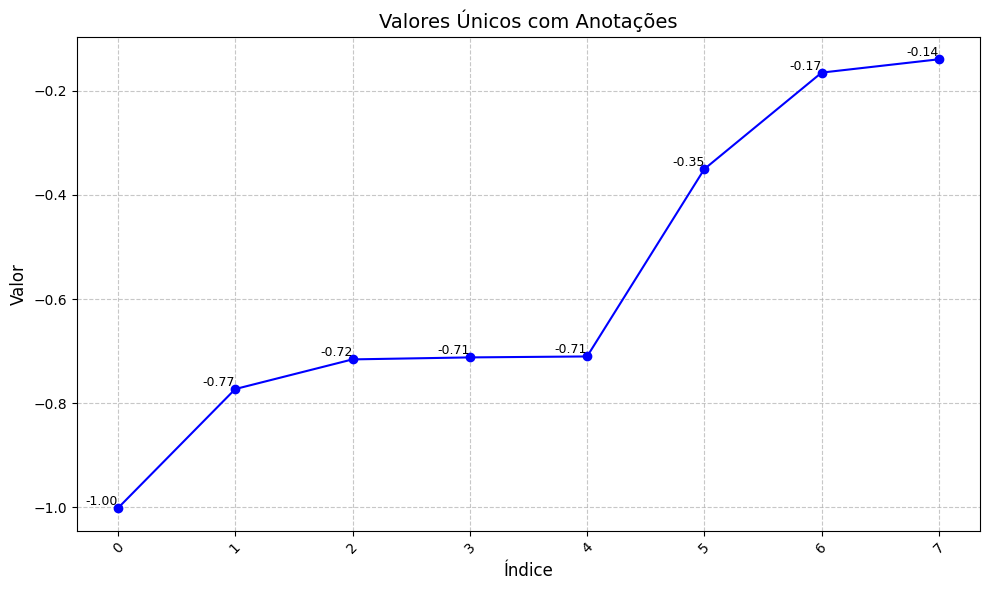

In [21]:
import matplotlib.pyplot as plt

valores_unicos = list(set(t))

valores_unicos.sort()

plt.figure(figsize=(10, 6))
plt.plot(valores_unicos, marker='o', linestyle='-', color='b')

for i, valor in enumerate(valores_unicos):
    plt.text(i, valor, f'{valor:.2f}', fontsize=9, ha='right', va='bottom')

plt.title('Valores Únicos com Anotações', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Valor', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.1.1 Dataframe dos Valores

In [22]:
print(y_pred) # Valores que foram previstos no predict
print(t)      # Valores retornados pelas árvores com o cálculo básico feito

[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]
[-0.7728314249999999, -0.7158851309999998, -0.712067231, -0.3503836783, -0.7728314249999999, -0.7158851309999998, -0.7728314249999999, -1.0013919280999999, -0.1652944104, -0.7728314249999999, -1.0013919280999999, -0.7158851309999998, -0.7158851309999998, -0.7158851309999998, -0.7158851309999998, -0.3503836783, -0.712067231, -0.7102380839999999, -0.7728314249999999, -0.712067231, -0.7158851309999998, -0.13970521096345473, -0.7158851309999998, -0.712067231, -0.712067231, -0.712067231, -0.712067231, -0.712067231, -0.7158851309999998, -0.7158851309999998]


In [23]:
import pandas as pd
df = pd.DataFrame({'y_pred': y_pred, 't': t})

df

,y_pred,t
0,1,-0.772831
1,0,-0.715885
2,2,-0.712067
3,1,-0.350384
4,1,-0.772831
5,0,-0.715885
6,1,-0.772831
7,2,-1.001392
8,1,-0.165294
9,1,-0.772831


## 3.2 Etapa de Interpretar os Dados

### 3.2.1 Cruzar informações com valores do y_pred e os valores retornados no myPredict

In [24]:
df = pd.DataFrame({'y_pred': y_pred, 't': t})

# filter dos dados
t_label_0 = df[df['y_pred'] == 0]['t'].tolist()  # t onde y_pred é 0
t_label_1 = df[df['y_pred'] == 1]['t'].tolist()  # t onde y_pred é 1
t_label_2 = df[df['y_pred'] == 2]['t'].tolist()  # t onde y_pred é 2

# mostrar resultados
print("Valores de t onde y_pred é 0:", t_label_0)
print("Valores de t onde y_pred é 1:", t_label_1)
print("Valores de t onde y_pred é 2:", t_label_2)


Valores de t onde y_pred é 0: [-0.7158851309999998, -0.7158851309999998, -0.7158851309999998, -0.7158851309999998, -0.7158851309999998, -0.7158851309999998, -0.7158851309999998, -0.7158851309999998, -0.7158851309999998, -0.7158851309999998]
Valores de t onde y_pred é 1: [-0.7728314249999999, -0.3503836783, -0.7728314249999999, -0.7728314249999999, -0.1652944104, -0.7728314249999999, -0.3503836783, -0.7102380839999999, -0.7728314249999999]
Valores de t onde y_pred é 2: [-0.712067231, -1.0013919280999999, -1.0013919280999999, -0.712067231, -0.712067231, -0.13970521096345473, -0.712067231, -0.712067231, -0.712067231, -0.712067231, -0.712067231]


In [25]:
print(list(set(t_label_0)))
print(list(set(t_label_1)))
print(list(set(t_label_2)))

[-0.7158851309999998]
[-0.7728314249999999, -0.7102380839999999, -0.1652944104, -0.3503836783]
[-0.712067231, -0.13970521096345473, -1.0013919280999999]


### 3.2.2 Verificar se há valores com interseção em diferentes labels (Não há)

In [26]:
# remove duplicatas
t_label_0_unicos = list(set(t_label_0))
t_label_1_unicos = list(set(t_label_1))
t_label_2_unicos = list(set(t_label_2))

# verif interseções
intersecao_0_1 = set(t_label_0_unicos).intersection(t_label_1_unicos)
intersecao_0_2 = set(t_label_0_unicos).intersection(t_label_2_unicos)
intersecao_1_2 = set(t_label_1_unicos).intersection(t_label_2_unicos)

print("Valores comuns entre t_label_0 e t_label_1:", intersecao_0_1)
print("Valores comuns entre t_label_0 e t_label_2:", intersecao_0_2)
print("Valores comuns entre t_label_1 e t_label_2:", intersecao_1_2)

Valores comuns entre t_label_0 e t_label_1: set()
Valores comuns entre t_label_0 e t_label_2: set()
Valores comuns entre t_label_1 e t_label_2: set()


### 3.2.3 Plotando dados

#### 3.2.3.1 Desordem

In [27]:
lista1 = t_label_0_unicos
lista2 = t_label_1_unicos
lista3 = t_label_2_unicos

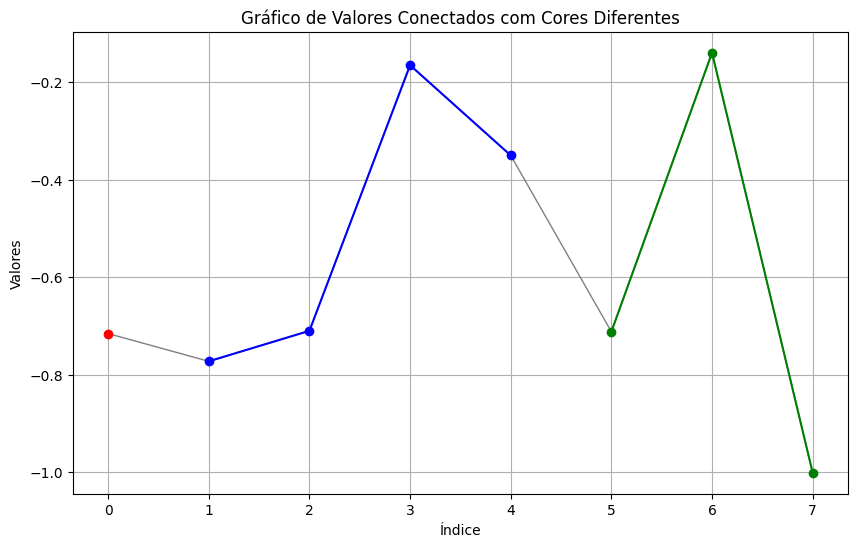

In [28]:
valores = lista1 + lista2 + lista3

x_values = [i for i in range(len(valores))]
plt.figure(figsize=(10, 6))

plt.plot(x_values, valores, color='grey', linestyle='-', linewidth=1)

cores = ['red', 'blue', 'green']

for i, lista in enumerate([lista1, lista2, lista3]):
    start_index = sum(len(lst) for lst in [lista1, lista2][:i])
    plt.plot(range(start_index, start_index + len(lista)), lista, marker='o', color=cores[i])

plt.title('Gráfico de Valores Conectados com Cores Diferentes')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.xticks(x_values)
plt.grid()
plt.show()

#### 3.2.3.1 Ordem

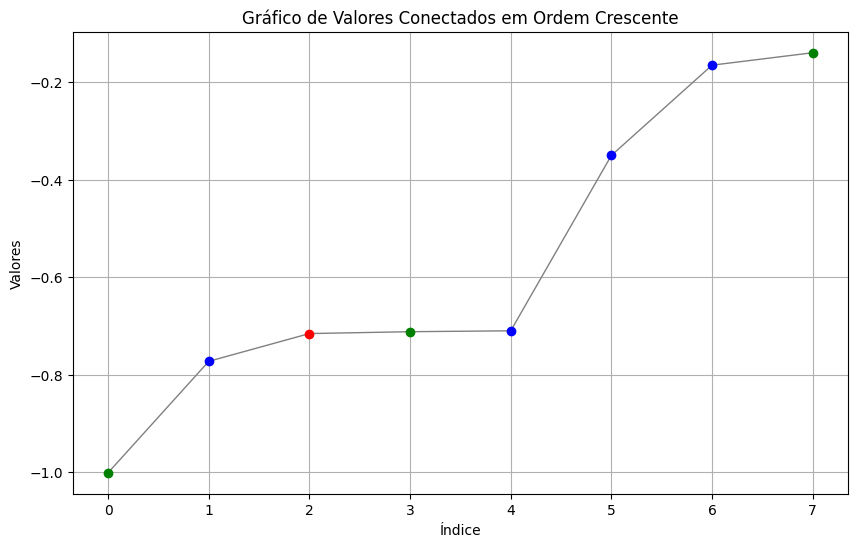

In [29]:
import matplotlib.pyplot as plt

valores = []
cores = ['red'] * len(lista1) + ['blue'] * len(lista2) + ['green'] * len(lista3)

valores.extend((value, 'red') for value in lista1)
valores.extend((value, 'blue') for value in lista2)
valores.extend((value, 'green') for value in lista3)

valores_sorted = sorted(valores, key=lambda x: x[0])
x_values = list(range(len(valores_sorted)))
plt.figure(figsize=(10, 6))

plt.plot(x_values, [v[0] for v in valores_sorted], color='grey', linestyle='-', linewidth=1)

for index, (value, color) in enumerate(valores_sorted):
    plt.plot(index, value, marker='o', color=color)

plt.title('Gráfico de Valores Conectados em Ordem Crescente')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.xticks(x_values)
plt.grid()
plt.show()


#### 3.2.3.1 Ordem com valores

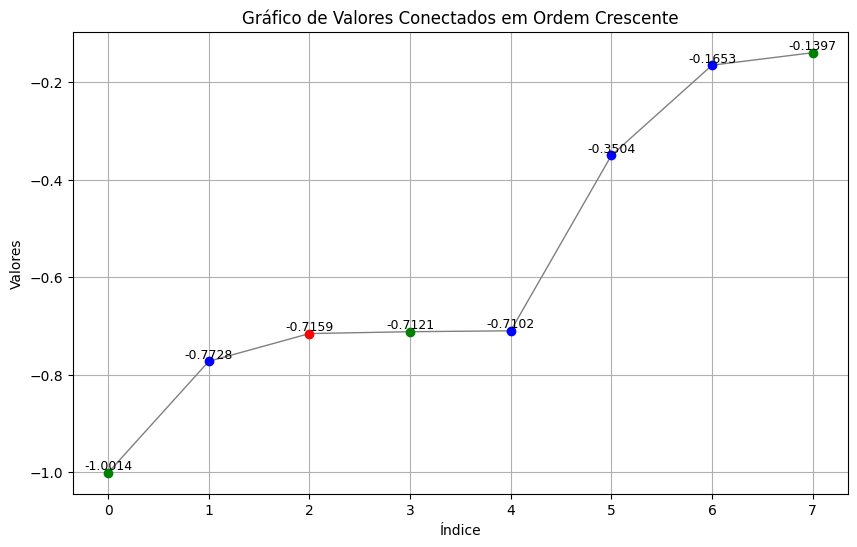

In [30]:
import matplotlib.pyplot as plt

valores = []
cores = ['red'] * len(lista1) + ['blue'] * len(lista2) + ['green'] * len(lista3)

valores.extend((value, 'red') for value in lista1)
valores.extend((value, 'blue') for value in lista2)
valores.extend((value, 'green') for value in lista3)

valores_sorted = sorted(valores, key=lambda x: x[0])
x_values = list(range(len(valores_sorted)))
plt.figure(figsize=(10, 6))

plt.plot(x_values, [v[0] for v in valores_sorted], color='grey', linestyle='-', linewidth=1)

for index, (value, color) in enumerate(valores_sorted):
    plt.plot(index, value, marker='o', color=color)
    plt.text(index, value, f'{value:.4f}', fontsize=9, ha='center', va='bottom')

plt.title('Gráfico de Valores Conectados em Ordem Crescente')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.xticks(x_values)
plt.grid()
plt.show()


# 4 - Decifrando Como Foi Passado Pelas Árvores

## 4.1 Todas as Amostras

In [31]:
import json
import numpy as np

def load_trees_from_json(file_path):
    with open(file_path, 'r') as f:
        trees = json.load(f)
    return trees

def predict_single(tree, sample):
    node = tree
    path = []
    while 'leaf' not in node:
        split_feature = int(node['split'][1:])  # extrai o índice da feature, ex: 'f2' -> 2
        split_condition = node['split_condition']

        if sample[split_feature] < split_condition:
            path.append((node['nodeid'], 'yes', split_feature, split_condition))
            node = next(child for child in node['children'] if child['nodeid'] == node['yes'])
        else:
            path.append((node['nodeid'], 'no', split_feature, split_condition))
            node = next(child for child in node['children'] if child['nodeid'] == node['no'])

    return node['leaf'], path

def predict(trees, samples):
    predictions = []
    for sample in samples:
        pred = 0
        for i, tree in enumerate(trees):
            leaf_value, path = predict_single(tree, sample)
            print(f"Árvore {i + 1}: Caminho = {path}, Valor da folha = {leaf_value}")
            pred += leaf_value
        predictions.append(pred)
        print('\n'*3)
    return predictions

if __name__ == "__main__":
    t = list()
    trees = load_trees_from_json('trees.json')

    predictions = predict(trees, X_test)


Árvore 1: Caminho = [(0, 'no', 2, 3)], Valor da folha = -0.218845025
Árvore 2: Caminho = [(0, 'no', 2, 3), (2, 'yes', 3, 1.79999995), (3, 'yes', 2, 5)], Valor da folha = 0.409090936
Árvore 3: Caminho = [(0, 'yes', 2, 4.80000019), (1, 'yes', 3, 1.5)], Valor da folha = -0.217894763
Árvore 4: Caminho = [(0, 'no', 2, 3)], Valor da folha = -0.195829004
Árvore 5: Caminho = [(0, 'no', 2, 3), (2, 'yes', 3, 1.79999995), (3, 'yes', 2, 5), (5, 'no', 0, 5.0999999)], Valor da folha = 0.295994341
Árvore 6: Caminho = [(0, 'yes', 2, 4.80000019), (1, 'yes', 3, 1.5)], Valor da folha = -0.194471359
Árvore 7: Caminho = [(0, 'no', 2, 3)], Valor da folha = -0.180574298
Árvore 8: Caminho = [(0, 'no', 2, 3), (2, 'yes', 3, 1.70000005), (3, 'yes', 2, 5)], Valor da folha = 0.239865407
Árvore 9: Caminho = [(0, 'yes', 2, 4.80000019), (1, 'yes', 3, 1.5)], Valor da folha = -0.178786531
Árvore 10: Caminho = [(0, 'no', 2, 3)], Valor da folha = -0.169575661
Árvore 11: Caminho = [(0, 'no', 2, 3), (2, 'yes', 3, 1.7000000

/usr/local/lib/python3.10/dist-packages/xgboost/plotting.py:284: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1, 1)


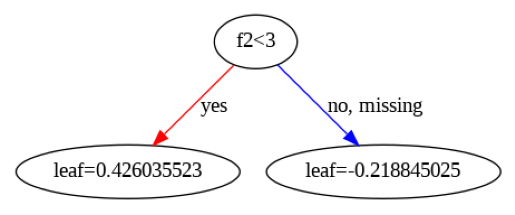

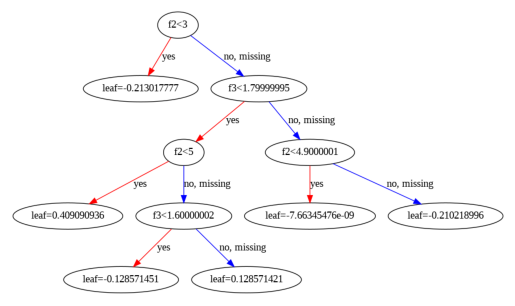

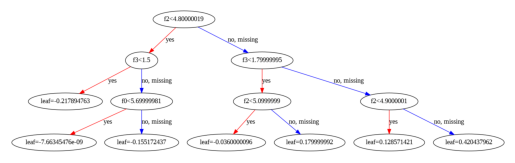

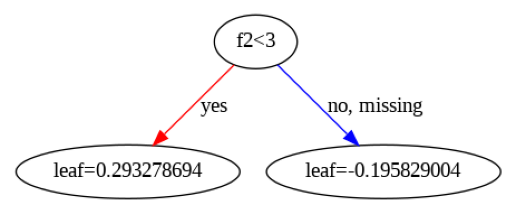

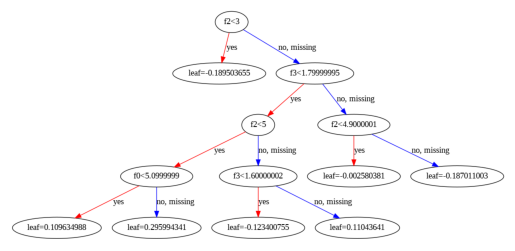

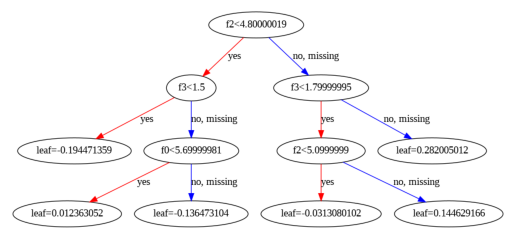

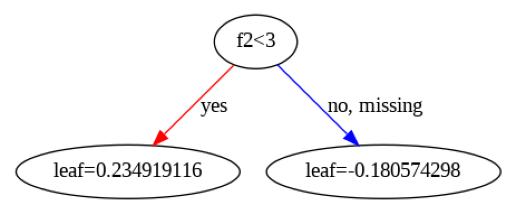

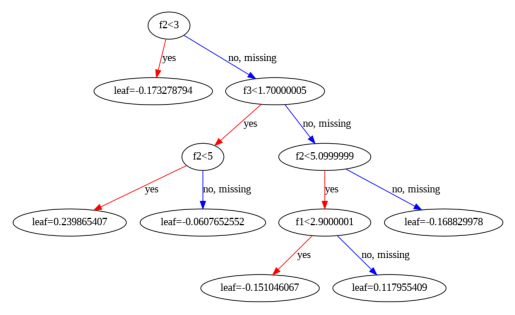

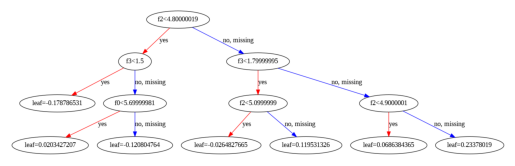

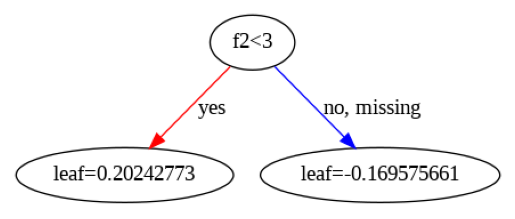

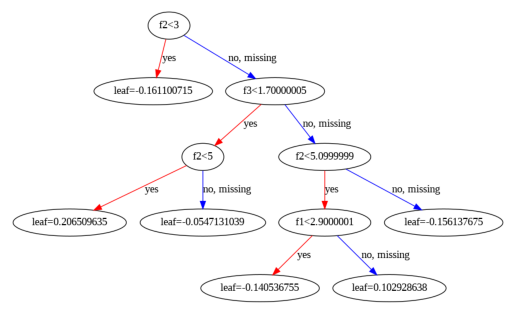

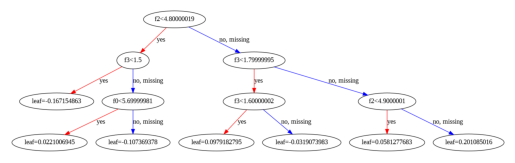

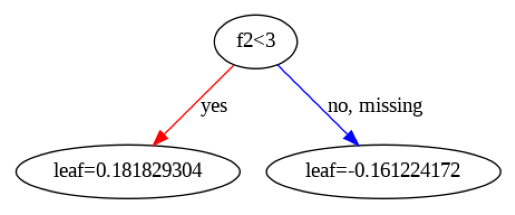

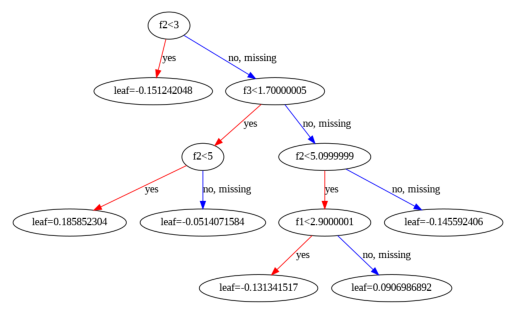

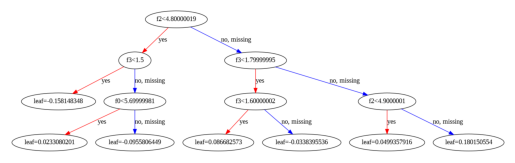

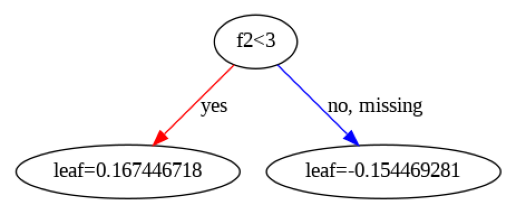

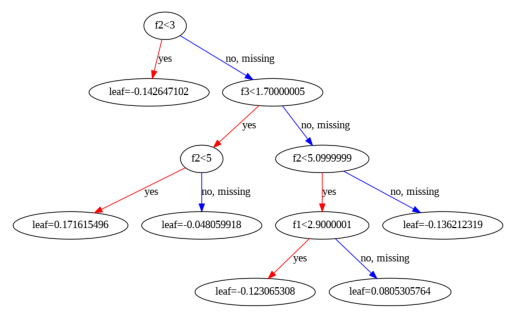

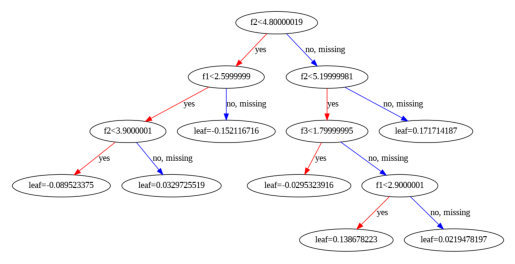

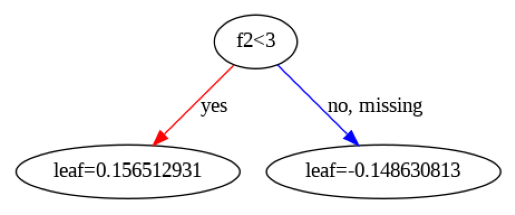

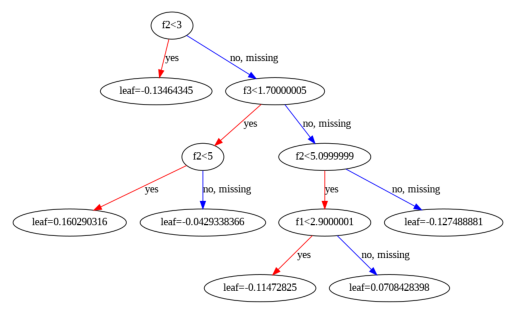

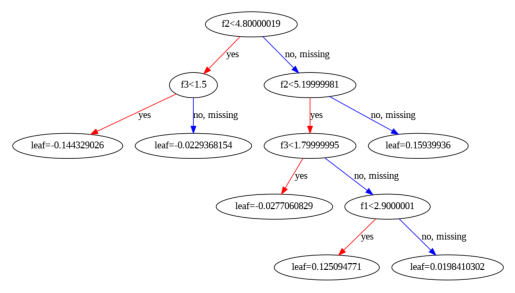

In [32]:
for i in range(len(trees)):
  xgb.plot_tree(model, num_trees=i)

## 4.2 Todas as Amostras Dataframe

In [33]:
import json
import numpy as np
import pandas as pd

def load_trees_from_json(file_path):
    with open(file_path, 'r') as f:
        trees = json.load(f)
    return trees

def predict_single(tree, sample):
    node = tree
    path = []
    while 'leaf' not in node:
        split_feature = int(node['split'][1:])
        split_condition = node['split_condition']

        if sample[split_feature] < split_condition:
            path.append({
                'Nó ID': node['nodeid'],
                'Condição': 'yes',
                'Feature Index': split_feature,
                'Condição de Divisão': split_condition
            })
            node = next(child for child in node['children'] if child['nodeid'] == node['yes'])
        else:
            path.append({
                'Nó ID': node['nodeid'],
                'Condição': 'no',
                'Feature Index': split_feature,
                'Condição de Divisão': split_condition
            })
            node = next(child for child in node['children'] if child['nodeid'] == node['no'])

    return node['leaf'], path

def predict(trees, samples):
    predictions = []
    for sample in samples:
        sample_results = []
        pred = 0
        for i, tree in enumerate(trees):
            leaf_value, path = predict_single(tree, sample)
            sample_results.append({
                'Árvore': i + 1,
                'Caminho': path,
                'Valor da Folha': leaf_value
            })
            pred += leaf_value

        predictions.append({
            'Predição Total': pred,
            'Resultados por Árvore': sample_results
        })
    return predictions

if __name__ == "__main__":
    t = list()
    trees = load_trees_from_json('trees.json')
    predictions = predict(trees, X_test)

    data = []
    for idx, pred in enumerate(predictions):
        for result in pred['Resultados por Árvore']:
            data.append({
                'Amostra': idx + 1,
                'Árvore': result['Árvore'],
                'Caminho': result['Caminho'],
                'Valor da Folha': result['Valor da Folha'],
                'Predição Total': pred['Predição Total']
            })

    df_results = pd.DataFrame(data)
    print(df_results)


     Amostra  Árvore                                            Caminho  \
0          1       1  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
1          1       2  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
2          1       3  [{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...   
3          1       4  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
4          1       5  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
..       ...     ...                                                ...   
625       30      17  [{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...   
626       30      18  [{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...   
627       30      19  [{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...   
628       30      20  [{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...   
629       30      21  [{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...   

     Valor da Folha  Predição Total  
0         -0.218845       -0.772831  
1          0.409091    

In [34]:
df_results

,Amostra,Árvore,Caminho,Valor da Folha,Predição Total
0,1,1,"[{'Nó ID': 0, 'Condição': 'no', 'Feature Index...",-0.218845,-0.772831
1,1,2,"[{'Nó ID': 0, 'Condição': 'no', 'Feature Index...",0.409091,-0.772831
2,1,3,"[{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...",-0.217895,-0.772831
3,1,4,"[{'Nó ID': 0, 'Condição': 'no', 'Feature Index...",-0.195829,-0.772831
4,1,5,"[{'Nó ID': 0, 'Condição': 'no', 'Feature Index...",0.295994,-0.772831
...,...,...,...,...,...
625,30,17,"[{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...",-0.142647,-0.715885
626,30,18,"[{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...",-0.152117,-0.715885
627,30,19,"[{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...",0.156513,-0.715885
628,30,20,"[{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...",-0.134643,-0.715885


## 4.3 Única Amostra Dataframe

In [35]:
import json
import numpy as np
import pandas as pd

def load_trees_from_json(file_path):
    with open(file_path, 'r') as f:
        trees = json.load(f)
    return trees

def predict_single(tree, sample):
    node = tree
    path = []
    while 'leaf' not in node:
        split_feature = int(node['split'][1:])
        split_condition = node['split_condition']

        if sample[split_feature] < split_condition:
            path.append({
                'Nó ID': node['nodeid'],
                'Condição': 'yes',
                'Feature Index': split_feature,
                'Condição de Divisão': split_condition
            })
            node = next(child for child in node['children'] if child['nodeid'] == node['yes'])
        else:
            path.append({
                'Nó ID': node['nodeid'],
                'Condição': 'no',
                'Feature Index': split_feature,
                'Condição de Divisão': split_condition
            })
            node = next(child for child in node['children'] if child['nodeid'] == node['no'])

    return node['leaf'], path

def predict(trees, samples):
    predictions = []
    for sample in samples:
        sample_results = []
        pred = 0
        for i, tree in enumerate(trees):
            leaf_value, path = predict_single(tree, sample)
            sample_results.append({
                'Árvore': i + 1,
                'Caminho': path,
                'Valor da Folha': leaf_value
            })
            pred += leaf_value

        predictions.append({
            'Predição Total': pred,
            'Resultados por Árvore': sample_results
        })
    return predictions

if __name__ == "__main__":
    trees = load_trees_from_json('trees.json')
    predictions = predict(trees, [X_test[0]])

    data = []
    for idx, pred in enumerate(predictions):
        for result in pred['Resultados por Árvore']:
            data.append({
                'Amostra': idx + 1,
                'Árvore': result['Árvore'],
                'Caminho': result['Caminho'],
                'Valor da Folha': result['Valor da Folha'],
                'Predição Total': pred['Predição Total']
            })

    df_results = pd.DataFrame(data)
    print(df_results)


    Amostra  Árvore                                            Caminho  \
0         1       1  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
1         1       2  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
2         1       3  [{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...   
3         1       4  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
4         1       5  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
5         1       6  [{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...   
6         1       7  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
7         1       8  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
8         1       9  [{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...   
9         1      10  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
10        1      11  [{'Nó ID': 0, 'Condição': 'no', 'Feature Index...   
11        1      12  [{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...   
12        1      13  [{'Nó ID': 0, 'Co

In [36]:
df_results

,Amostra,Árvore,Caminho,Valor da Folha,Predição Total
0,1,1,"[{'Nó ID': 0, 'Condição': 'no', 'Feature Index...",-0.218845,-0.772831
1,1,2,"[{'Nó ID': 0, 'Condição': 'no', 'Feature Index...",0.409091,-0.772831
2,1,3,"[{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...",-0.217895,-0.772831
3,1,4,"[{'Nó ID': 0, 'Condição': 'no', 'Feature Index...",-0.195829,-0.772831
4,1,5,"[{'Nó ID': 0, 'Condição': 'no', 'Feature Index...",0.295994,-0.772831
5,1,6,"[{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...",-0.194471,-0.772831
6,1,7,"[{'Nó ID': 0, 'Condição': 'no', 'Feature Index...",-0.180574,-0.772831
7,1,8,"[{'Nó ID': 0, 'Condição': 'no', 'Feature Index...",0.239865,-0.772831
8,1,9,"[{'Nó ID': 0, 'Condição': 'yes', 'Feature Inde...",-0.178787,-0.772831
9,1,10,"[{'Nó ID': 0, 'Condição': 'no', 'Feature Index...",-0.169576,-0.772831


# 5 - Plot Árvores

/usr/local/lib/python3.10/dist-packages/xgboost/plotting.py:284: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1, 1)


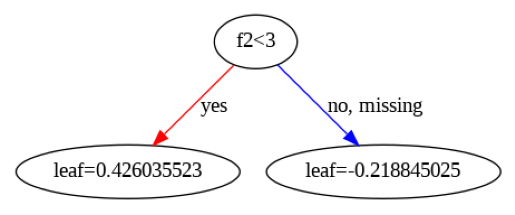

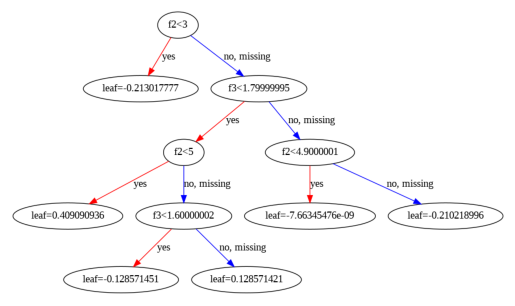

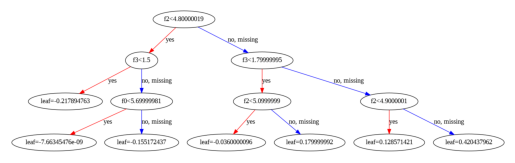

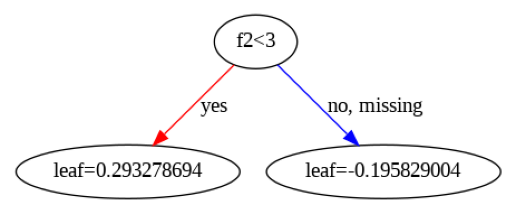

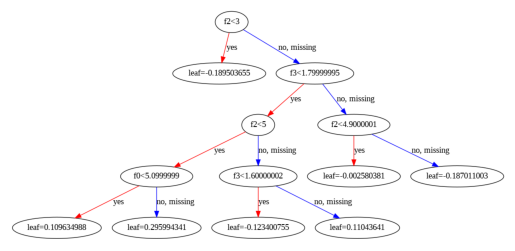

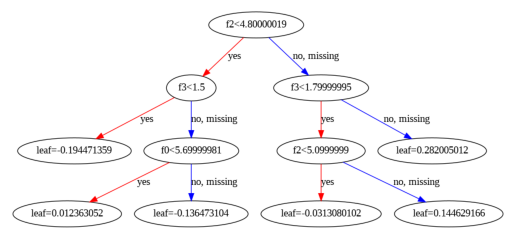

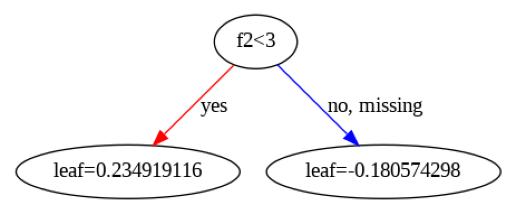

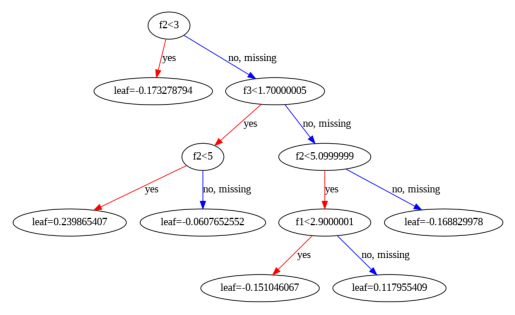

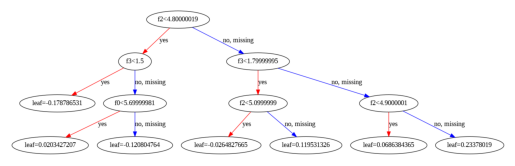

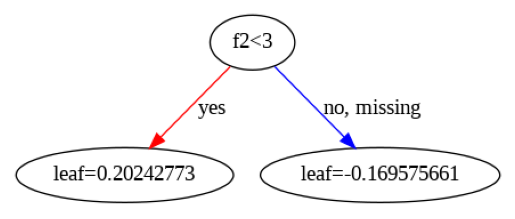

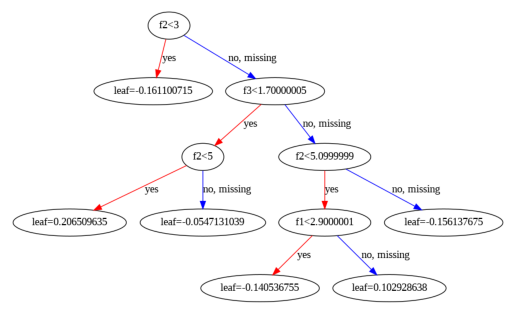

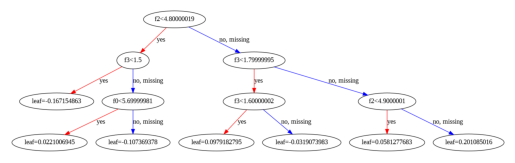

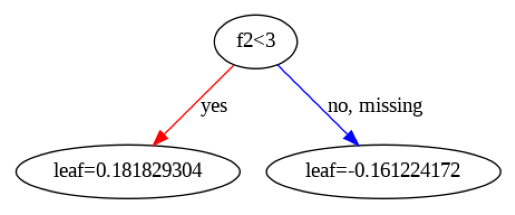

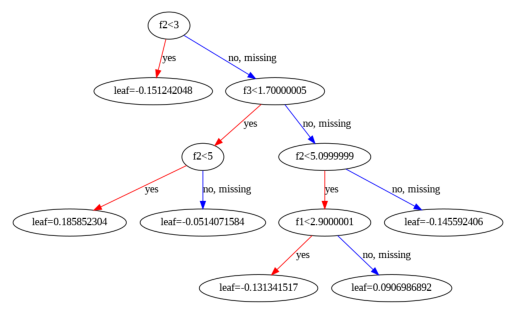

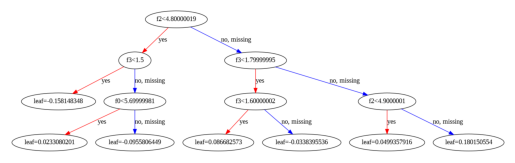

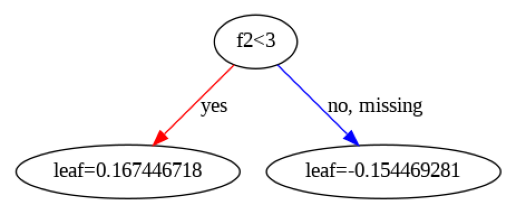

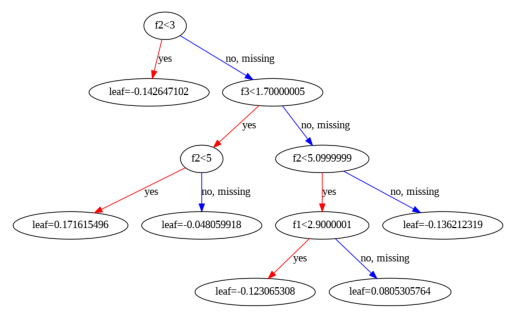

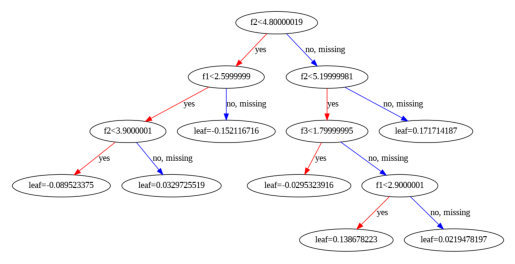

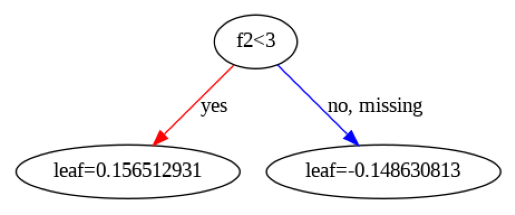

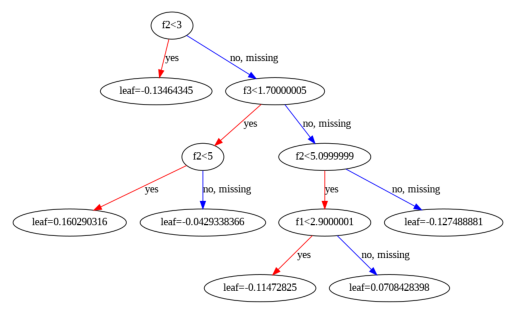

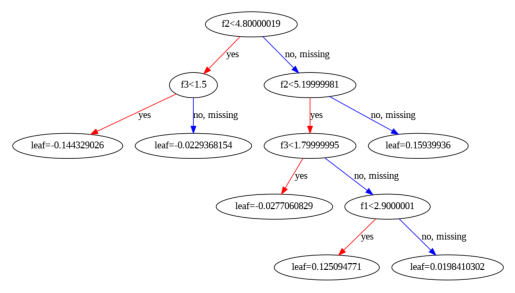

In [37]:
for i in range(len(trees)):
  xgb.plot_tree(model, num_trees=i)